# Democratic Caucus Trader Analysis

This notebook does some analysis on trader behavior in the Democratic Caucus market.

In [1]:
import os
import sys
import re
from collections import defaultdict
from functools import lru_cache

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, Panel

idx = pd.IndexSlice

from research_tools import storage

pd.options.display.float_format = lambda x: '{:,.4f}'.format(x) if abs(x) < 1 else '{:,.2f}'.format(x)

# Load Data

First, load the data. All of the data is organized in nice, standardized formats.

In [2]:
os.chdir('..')

basename = 'dem'

orders, behavior_analysis, trader_analysis, quotes_dict = storage.retrieve_all(
    [basename + '.orders',
     basename + '.behavior_analysis',
     basename + '.trader_analysis',
     basename + '.reconstructed_quotes'])

Reading data from data/dem.orders.p
Reading data from data/dem.behavior_analysis.p
Reading data from data/dem.trader_analysis.p
Reading data from data/dem.reconstructed_quotes.p


# Trader Stats Calculations

Calculate statistics on the trading results of each trader.

We want to know what the spread profits are and the profits resulting from biased prices (prices that sum to more than $1).

To do this we first need to join the trade data with our reconstructed quotes.

## Join quote data with trade data

In [3]:
def add_contract_id(df, contract_id):
    df = df.drop('timestamp', axis=1).copy()
    df['contract_id'] = contract_id
    return df

quotes = pd.concat([add_contract_id(df, c_id) for c_id, df in quotes_dict.items()]).sort_index()

trader_analysis = pd.merge_asof(trader_analysis.sort_values('seq'),
                                quotes,
                                by='contract_id',
                                left_on='seq',
                                right_index=True,
                                allow_exact_matches=True).sort_index()

# joining with bid/ask prices for Close trades doesn't make any sense
trader_analysis.loc[trader_analysis['trade_type'] == 'Close', ['bid_price', 'ask_price']] = np.nan

trader_analysis['mid_price'] = trader_analysis[['bid_price', 'ask_price']].mean(axis=1)

## Calculate Spread Profits

Now that we know what the prevailing bid-ask prices are at the time of each trade, we can calculate the spread profits. Provide trades are earning a spread profit and take trades are paying the spread.

Close trades are a special trade with the exchange for \\$1 or \\$0.

In [4]:
trader_analysis['spread_profit'] = trader_analysis.eval("corrected_side * quantity * (mid_price - corrected_price)")

# Close trades have no spread profits
trader_analysis.loc[trader_analysis['trade_type'] == 'Close', 'spread_profit'] = 0

## Calculate Bias Profits

To calculate the price biases we must first find the sum of the bid-ask prices. This is the same code used in the other notebooks analyzing the quotes.

In [5]:
def make_interval_quotes(df):
    df = df.set_index('timestamp')

    start = df.index[0].floor('1Min')
    end = df.index[-1].floor('1Min')

    timestamp_intervals = pd.date_range(start, end, freq='1Min')

    return df[['bid_price', 'ask_price']].apply(lambda x: x.asof(timestamp_intervals)).bfill()

def make_quote_panel(quotes):
    quotes_intervals = {c_id: make_interval_quotes(df) for c_id, df in quotes.items()}

    start = min([df.index[0] for df in quotes_intervals.values()])
    end = max([df.index[-1] for df in quotes_intervals.values()])
    timestamp_intervals = pd.date_range(start, end, freq='1Min')

    panel = Panel({c_id: df.loc[timestamp_intervals].ffill().bfill() for c_id, df in quotes_intervals.items()})
    
    return panel

quotes_panel = make_quote_panel(quotes_dict)
quotes_sum = quotes_panel.sum(axis=0)
quotes_sum.columns = ['bid_price_sums', 'ask_price_sums']

Using `quotes_sum` we can calculate the mid and use it as a normalization factor.

Close trades are always at an unbiased price.

In [6]:
quotes_sum['norm_factor'] = quotes_sum.mean(axis=1)

quotes_sum['timestamp'] = quotes_sum.index
quotes_sum['seq'] = quotes_sum['timestamp'].apply(lambda t: int(int(t.to_datetime64()) / 1e6))

price_bias_norm_factor = quotes_sum.set_index('seq')[['norm_factor']]

trader_analysis = pd.merge_asof(trader_analysis.sort_values('seq'),
                                price_bias_norm_factor,
                                left_on='seq',
                                right_index=True,
                                allow_exact_matches=True).sort_index()

trader_analysis['bias_profit'] = trader_analysis.eval("corrected_side * quantity * mid_price * (1 / norm_factor - 1)")

# Close trades always at an unbiased price
trader_analysis.loc[trader_analysis['trade_type'] == 'Close', 'norm_factor'] = 1
trader_analysis.loc[trader_analysis['trade_type'] == 'Close', 'bias_profit'] = 0

In [7]:
def stats(trades):
    out = Series()
    
    total_nonclose = trades[~trades.close_trade].quantity.sum()
    out['take_pct'] = trades.query("take_provide == 'T' and not close_trade").quantity.sum() / total_nonclose
    out['longshot_pct'] = trades.query("price_per_share <= 0.1 and not close_trade").quantity.sum() / total_nonclose
    out['antilongshot_pct'] = trades.query("price_per_share >= 0.9 and not close_trade").quantity.sum() / total_nonclose

    return out

df = orders.groupby('user_guid')['order_id'].count().to_frame('orders_sent')
df2 = trader_analysis.groupby(['user_guid'])[['quantity', 'notional', 'spread_profit', 'bias_profit',
                                              'gross_pnl', 'fee', 'pnl_net_fee']].sum()
df3 = trader_analysis.groupby(['user_guid']).apply(stats)

trader_stats_summary = df.merge(df2, left_index=True, right_index=True).merge(df3, left_index=True, right_index=True)
trader_stats_summary.sort_values('pnl_net_fee', ascending=False, inplace=True)

# position profit is the profit on directional price moves
# calculate this for trader_stats_summary, not trader_analysis
trader_stats_summary['position_profit'] = trader_stats_summary.eval('gross_pnl - spread_profit - bias_profit')

trader_stats_summary = trader_stats_summary[['orders_sent', 'quantity', 'notional', 'spread_profit',
                                             'bias_profit', 'position_profit', 'gross_pnl', 'fee', 'pnl_net_fee',
                                             'take_pct', 'longshot_pct', 'antilongshot_pct']]

Here's what that looks like. The DataFrame shows the PnL breakdown for each trader.

In [8]:
trader_stats_summary.head()

,orders_sent,quantity,notional,spread_profit,bias_profit,position_profit,gross_pnl,fee,pnl_net_fee,take_pct,longshot_pct,antilongshot_pct
user_guid,,,,,,,,,,,,
C4D5B846-1FD3-31DB-BA4C-9223A8633708,6,6038,"4,718.51",10.47,-22.06,"1,331.08","1,319.49",131.95,"1,187.54",0.2136,0.0000,0.0000
9D326C8B-8DE3-3A23-8D20-E2B1A332FAB9,10,6034,"4,716.10",36.94,-25.52,"1,306.48","1,317.90",131.79,"1,186.11",0.0603,0.0000,0.0000
A5D275E7-E1CA-3003-ABB8-00947B491947,47,7392,"6,014.55",58.17,3.79,"1,252.99","1,314.95",131.49,"1,183.45",0.2024,0.0000,0.4470
738E8484-0BDA-3B96-84DC-A110B70DF314,9,5948,"4,673.58",62.61,-24.13,"1,235.94","1,274.42",127.44,"1,146.98",0.0121,0.0000,0.0000
34A305EF-1ED6-3B2D-9F7D-0A90C7B7A787,75,6708,"4,880.55",-5.90,38.32,"1,154.81","1,187.23",120.95,"1,066.28",0.7508,0.0000,0.0198


## Trader Subgroups

We can use our behavior analysis to divide the traders into subgroups. The traders had different levels of engagement with the market and different approaches to trading. These choices had a big impact on the resulting profits.

Some traders traded efficiently and others were inefficient. If 75% or more of a trader's volume is for trades that were not strictly dominated by another group of trades, the trader is deemed an efficient trader. If not, they are deemed an inefficient trader.

Some traders were very active and some were not. If a trader opened and closed a position in the same contract multiple times they are deemed an active trader. If they did not they are deemed an inactive trader.

Some traders traded in small sizes and some traded in large sizes. If a trader's max loss was ever more than $50 they are deemed a large trader. If not, they are deemed a small trader.

There were 3,750 traders in this market, less than the 5000 trader limit.

## Efficiency

Many traders only made one trade. Those traders will either be 100% efficient or 0% efficient.

About one third of the traders traded efficiently at least 75% of the time.

In [9]:
(behavior_analysis.efficiency >= 0.75).sum() / len(behavior_analysis)

0.32213333333333333

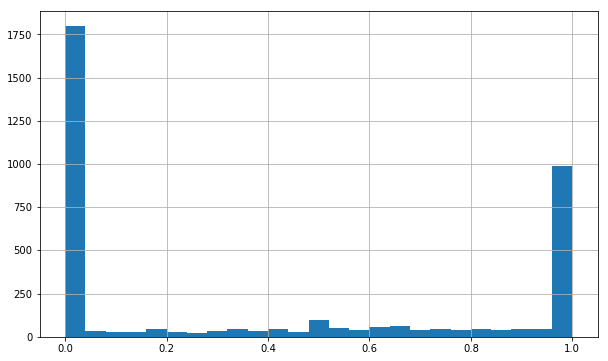

In [10]:
behavior_analysis.efficiency.hist(bins=25, figsize=(10, 6))

## Activity

Again, many traders made only one trade. Obviously those traders only opened 1 position on that one contract.

Even for traders that made more than one trade, many did not open and close positions on the same contract multiple times. Only about 15% can be considered active, opening and closing positions on the same contract. The remaining 85% are inactive.

In [11]:
(behavior_analysis.max_opened_pos == 1).sum() / len(behavior_analysis)

0.8541333333333333

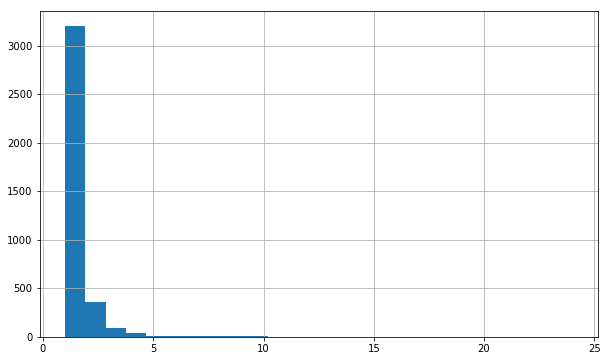

In [12]:
behavior_analysis.max_opened_pos.hist(bins=25, figsize=(10, 6))

## Size

Most traders traded in small sizes. About 72% never risked more than \\$50. About 28% did, with some hitting the risk limit of \\$850 per contract.

In [13]:
(behavior_analysis.max_loss > 50).sum() / len(behavior_analysis)

0.28239999999999998

The maximum max-loss is $1700, suggesting that some traders were hitting the risk limit of for 2 candidates.

In [14]:
behavior_analysis.max_loss.max()

1700.0000000000414

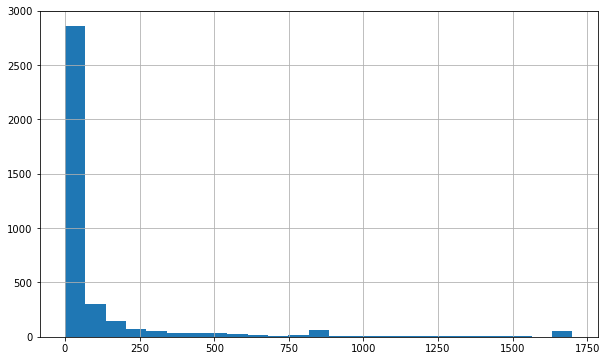

In [15]:
behavior_analysis.max_loss.hist(bins=25, figsize=(10, 6))

# Trader Group Breakdown

Next we analyze the PnL of the traders by dividing by the above three metrics. The goal is to see how profitable their trading activities were. We also decompose the PnL to see where the profits and losses were coming from.

In [16]:
def make_group_stats(group_name, query, per_trader=False):
    out = Series()

    if query:
        group = behavior_analysis.query(query).index
    else:
        group = behavior_analysis.index
    out['trader_count'] = len(group)
    out['orders_sent'] = len(orders.set_index('user_guid').loc[group])
    out = out.append(trader_analysis.set_index('user_guid').loc[group][['quantity', 'notional', 'spread_profit',
                                                                        'bias_profit',
                                                                        'gross_pnl', 'fee', 'pnl_net_fee']].sum())
    out['position_profit'] = out['gross_pnl'] - out['spread_profit'] - out['bias_profit']
    out['sum_max_loss'] = behavior_analysis.loc[group, 'max_loss'].sum()
    out['sum_max_in_pool'] = behavior_analysis.loc[group, 'max_in_pool'].sum()
    out['gross_roi'] = out['gross_pnl'] / out['sum_max_in_pool']
    out['net_roi'] = out['pnl_net_fee'] / out['sum_max_in_pool']

    out = out.append(stats(trader_analysis.set_index('user_guid').loc[group]))
    
    out.name = group_name

    if per_trader:
        out2 = out / out['trader_count']
        out2['trader_count'] = out['trader_count']

        return out2[['trader_count', 'orders_sent', 'quantity', 'notional', 'spread_profit', 'bias_profit',
               'position_profit', 'gross_pnl', 'fee', 'pnl_net_fee']].to_frame()
    else:
        return out[['trader_count', 'orders_sent', 'quantity', 'notional',
                    'sum_max_loss', 'sum_max_in_pool', 'spread_profit',
                    'bias_profit', 'position_profit', 'gross_pnl', 'fee',
                    'pnl_net_fee', 'gross_roi', 'net_roi',  'take_pct', 'longshot_pct',
                    'antilongshot_pct']].to_frame()

def make_multi_group_stats(groups, **args):
    return pd.concat([make_group_stats(*g, **args) for g in groups], axis=1)

Before looking at the numbers, consider the fact that without fees these markets are zero sum games. This means that gross PnL across all the traders is a zero sum game.

Now consider a hypothetical PredictIt market with no fees, spreads, or biased prices (meaning the sum of the Yes contract prices always equals $1). The only way to make money in this market is by being better at predicting future prices, ie, position profits.

In such a market imagine that there is a subset of traders that are superior at information analysis and prediction. They would make better trades. Over time they would win more money than they would lose. If this was the case we would see a net flow of cash from traders that are not in this group to traders that are in the group. This net flow of cash would also be *reliable* in that we would see this across markets.

Now imagine that all traders are making bets by throwing darts at the wall. In this market there would be no way to reliably segment the market such that we would see a net flow of cash between groups.

What we will see below is that there are segments where money is moving from one group to another. In particular, from inefficient traders to efficient traders. And what is even more interesting is *why* that money is flowing between the two groups.

## Trader Efficiency

As one might expect (or hope), as a group the efficient traders were also profitable.

In [17]:
groups = [
    ('Everyone', None),
    ('Efficient_Traders', 'efficiency >= 0.75'),
    ('Inefficient_Traders', 'efficiency < 0.75')
]

make_multi_group_stats(groups)

,Everyone,Efficient_Traders,Inefficient_Traders
trader_count,"3,750.00","1,208.00","2,542.00"
orders_sent,"33,959.00","16,181.00","17,778.00"
quantity,"2,642,398.00","1,267,800.00","1,374,598.00"
notional,"1,271,811.34","578,534.61","693,276.73"
sum_max_loss,"416,727.65","152,410.55","264,317.10"
sum_max_in_pool,"417,251.70","150,529.96","266,721.74"
spread_profit,-0.0000,"3,435.75","-3,435.75"
bias_profit,-0.0000,"5,436.13","-5,436.13"
position_profit,0.0000,"8,183.21","-8,183.21"
gross_pnl,0.0000,"17,055.09","-17,055.09"


In this market, \\$17k flowed from inefficient traders to efficient traders. Why did \\$17k flow between these two groups?

Only \\$8k is from position profits. This is 48%. This is less than half. Compare this to the ideal market with no spreads or biased prices where position profits are the only way to make money.

\\$5.4k (32%) is from price biases and the remaining \\$3.4k (20%) is from market spreads.

Also consider that the efficient traders are grouped together because they didn't trade the strictly dominated contracts but they also had positive position profits, indicating that they were better are processing information. If these two things were uncorrelated the position_profit value here would be closer to zero. It isn't. This suggests that the ability to understand how markets work and trade efficiently is correlated to the ability to pick the right candidates to back.

Note I've also added a few more rows to this analysis. The "sum_max_in_pool" is the total of the maximum amount of money each trader had in the pool of cash any time during the life of this market. To calculate this we look for the notional exposure minus the accumulated pnl from closed out positions. It shows how big the capital pool is in the zero sum game and is critical for understanding the significance or scale of the numbers for a group. In particular, those two pnl numbers divided by the sum_max_in_pool value give the "gross_roi" and "net_roi". The efficient traders had a gross ROI of about 11%. For some groups these are rather notable. 

In [18]:
[x / 17055.09 for x in [8183.21, 5436.13, 3435.75]]

[0.47981042609567, 0.3187394496305795, 0.20145012427375053]

## Trader Size

Next is size. Most traders were small and did not risk more than \$50. As a group they lost money by paying the spread, trading inefficiently, and picking the wrong candidates.

In [19]:
groups = [
    ('Everyone', None),
    ('Small_Traders', 'max_loss <= 50'),
    ('Large_Traders', 'max_loss > 50')
]

make_multi_group_stats(groups)

,Everyone,Small_Traders,Large_Traders
trader_count,"3,750.00","2,691.00","1,059.00"
orders_sent,"33,959.00","10,180.00","23,779.00"
quantity,"2,642,398.00","209,074.00","2,433,324.00"
notional,"1,271,811.34","76,533.14","1,195,278.20"
sum_max_loss,"416,727.65","36,059.06","380,668.59"
sum_max_in_pool,"417,251.70","36,078.38","381,173.32"
spread_profit,-0.0000,-537.33,537.33
bias_profit,-0.0000,-723.32,723.32
position_profit,0.0000,"-7,095.50","7,095.50"
gross_pnl,0.0000,"-8,356.16","8,356.16"


Overall there was a net flow of cash from small traders to large traders. Net flow was over \$8k. Why did this happen? Mostly (85%) it was because of position profits.

The Small Traders' gross_roi is interesting. Negative 23%? That's really bad.

In [20]:
[x / -8356.16 for x in [-7095.50, -723.32, -537.33]]

[0.8491340520047486, 0.08656129131084135, 0.0643034599624708]

## Trader Activity

Finally, trader activity. The active traders were profitable. It seems reasonable that traders who are trading in larger sizes or more frequently would put in the effort to learn how to trade profitably. These traders earned the spread, picked the right candidates and traded efficiently.

In [21]:
groups = [
    ('Everyone', None),
    ('Active_Traders', 'max_opened_pos > 1'),
    ('Inactive_Traders', 'max_opened_pos == 1')
]

make_multi_group_stats(groups)

,Everyone,Active_Traders,Inactive_Traders
trader_count,"3,750.00",547.00,"3,203.00"
orders_sent,"33,959.00","19,862.00","14,097.00"
quantity,"2,642,398.00","1,466,988.00","1,175,410.00"
notional,"1,271,811.34","677,878.43","593,932.91"
sum_max_loss,"416,727.65","138,877.81","277,849.84"
sum_max_in_pool,"417,251.70","139,948.56","277,303.14"
spread_profit,-0.0000,"3,996.11","-3,996.11"
bias_profit,-0.0000,"1,719.04","-1,719.04"
position_profit,0.0000,"2,645.86","-2,645.86"
gross_pnl,0.0000,"8,361.01","-8,361.01"


As one might expect there was a net flow of money from inactive traders to active traders. The net flow was \$8.3k. Interestingly 48% of that was from spread profits. This is suggestive of liquidity providers.

In [22]:
[x / 8361.01 for x in [2645.86, 1719.04, 3996.11]]

[0.3164521989568246, 0.2056019547877589, 0.47794584625541653]

# Trader Subgroup Breakdown

Next we do the same thing but this time grouping the traders into smaller groups using multiple characteristics at the same time.

The following is for half of Table 6.

In [23]:
groups = [
    ('Everyone', None),
    ('Small_Active', 'max_opened_pos > 1 and max_loss <= 50'),
    ('Small_Inactive', 'max_opened_pos == 1 and max_loss <= 50'),
    ('Large_Active', 'max_opened_pos > 1 and max_loss > 50'),
    ('Large_Inactive', 'max_opened_pos == 1 and max_loss > 50')
]

make_multi_group_stats(groups).T['trader_count']

Everyone         3,750.00
Small_Active       252.00
Small_Inactive   2,439.00
Large_Active       295.00
Large_Inactive     764.00
Name: trader_count, dtype: float64

Now let's look at trading efficiency. How about large and small efficient traders?

In [24]:
groups = [
    ('Everyone', None),
    ('Efficient_Traders', 'efficiency >= 0.75'),
    ('Efficient_Traders:Small', 'efficiency >= 0.75 and max_loss <= 50'),
    ('Efficient_Traders:Large', 'efficiency >= 0.75 and max_loss > 50')
]

make_multi_group_stats(groups)

,Everyone,Efficient_Traders,Efficient_Traders:Small,Efficient_Traders:Large
trader_count,"3,750.00","1,208.00",808.00,400.00
orders_sent,"33,959.00","16,181.00","3,401.00","12,780.00"
quantity,"2,642,398.00","1,267,800.00","72,756.00","1,195,044.00"
notional,"1,271,811.34","578,534.61","25,577.41","552,957.20"
sum_max_loss,"416,727.65","152,410.55","11,179.24","141,231.31"
sum_max_in_pool,"417,251.70","150,529.96","11,131.57","139,398.39"
spread_profit,-0.0000,"3,435.75",-42.79,"3,478.54"
bias_profit,-0.0000,"5,436.13",518.59,"4,917.54"
position_profit,0.0000,"8,183.21","-1,690.59","9,873.80"
gross_pnl,0.0000,"17,055.09","-1,214.79","18,269.88"


The small efficient traders had position losses, indicating the backed the wrong candidates. The large and efficient traders earned more than half of their profits from position profits.

In [25]:
[x / 18269.88 for x in [9873.80, 4917.54, 3478.54]]

[0.5404414259973245, 0.26916104539274477, 0.19039752860993064]

The inefficient traders did badly regardless of whether or not they traded in large or small sizes.

In [26]:
groups = [
    ('Everyone', None),
    ('Inefficient_Traders', 'efficiency < 0.75'),
    ('Inefficient_Traders:Small', 'efficiency < 0.75 and max_loss <= 50'),
    ('Inefficient_Traders:Large', 'efficiency < 0.75 and max_loss > 50')
]

make_multi_group_stats(groups)

,Everyone,Inefficient_Traders,Inefficient_Traders:Small,Inefficient_Traders:Large
trader_count,"3,750.00","2,542.00","1,883.00",659.00
orders_sent,"33,959.00","17,778.00","6,779.00","10,999.00"
quantity,"2,642,398.00","1,374,598.00","136,318.00","1,238,280.00"
notional,"1,271,811.34","693,276.73","50,955.73","642,321.00"
sum_max_loss,"416,727.65","264,317.10","24,879.82","239,437.28"
sum_max_in_pool,"417,251.70","266,721.74","24,946.81","241,774.93"
spread_profit,-0.0000,"-3,435.75",-494.54,"-2,941.20"
bias_profit,-0.0000,"-5,436.13","-1,241.91","-4,194.22"
position_profit,0.0000,"-8,183.21","-5,404.91","-2,778.29"
gross_pnl,0.0000,"-17,055.09","-7,141.37","-9,913.72"


The Small and inefficient traders did poorly. Their gross pnl was -\\$7k but look at their sum_max_in_pool. They only risked \$25k. Their gross roi is -29%. This is not a small issue: there are 1883 traders in this group. This is 50% of the traders.

It isn't the case that these traders were all swinging for the fences with longshots. Their longshot_pct value is 7%, less than the value for everyone (9.7%).

In [27]:
[x / -7141.37 for x in [-5404.91, -1241.91, -494.54]]

[0.7568449751238208, 0.1739036067309214, 0.06925001785371715]

Now, efficiency and trading activity?

In [28]:
groups = [
    ('Everyone', None),
    ('Efficient_Traders', 'efficiency >= 0.75'),
    ('Efficient_Traders:Active', 'efficiency >= 0.75 and max_opened_pos > 1'),
    ('Efficient_Traders:Inactive', 'efficiency >= 0.75 and max_opened_pos == 1')
]

make_multi_group_stats(groups)

,Everyone,Efficient_Traders,Efficient_Traders:Active,Efficient_Traders:Inactive
trader_count,"3,750.00","1,208.00",204.00,"1,004.00"
orders_sent,"33,959.00","16,181.00","11,182.00","4,999.00"
quantity,"2,642,398.00","1,267,800.00","872,710.00","395,090.00"
notional,"1,271,811.34","578,534.61","360,140.59","218,394.02"
sum_max_loss,"416,727.65","152,410.55","59,317.23","93,093.32"
sum_max_in_pool,"417,251.70","150,529.96","57,696.28","92,833.68"
spread_profit,-0.0000,"3,435.75","4,128.50",-692.74
bias_profit,-0.0000,"5,436.13","2,566.73","2,869.40"
position_profit,0.0000,"8,183.21","-1,476.22","9,659.43"
gross_pnl,0.0000,"17,055.09","5,219.01","11,836.08"


The efficient and active traders were profitable in spite their negative position profits, indicating they picked the wrong candidates. Their spread profits are profitable. A trader functioning as a market maker will earn the spread but lose money on position profits. The spread profits will exceed the position losses. Also observe the low take percentage.

The efficient and inactivate traders were also profitable but interestingly made most of their profits from position profits. They lost money on the spread. These two groups were functioning very differently.

Now the inefficient traders. How did they do broken down by trading activity?

In [29]:
groups = [
    ('Everyone', None),
    ('Inefficient_Traders', 'efficiency < 0.75'),
    ('Inefficient_Traders:Active', 'efficiency < 0.75 and max_opened_pos > 1'),
    ('Inefficient_Traders:Inactive', 'efficiency < 0.75 and max_opened_pos == 1')
]

make_multi_group_stats(groups)

,Everyone,Inefficient_Traders,Inefficient_Traders:Active,Inefficient_Traders:Inactive
trader_count,"3,750.00","2,542.00",343.00,"2,199.00"
orders_sent,"33,959.00","17,778.00","8,680.00","9,098.00"
quantity,"2,642,398.00","1,374,598.00","594,278.00","780,320.00"
notional,"1,271,811.34","693,276.73","317,737.84","375,538.89"
sum_max_loss,"416,727.65","264,317.10","79,560.58","184,756.52"
sum_max_in_pool,"417,251.70","266,721.74","82,252.27","184,469.46"
spread_profit,-0.0000,"-3,435.75",-132.38,"-3,303.37"
bias_profit,-0.0000,"-5,436.13",-847.69,"-4,588.44"
position_profit,0.0000,"-8,183.21","4,122.08","-12,305.28"
gross_pnl,0.0000,"-17,055.09","3,142.00","-20,197.09"


Interestingly the inefficient traders who traded actively were able to earn positive position profits. They lost money by trading inefficiently but not enough to put them in the red.

The inefficient and inactive traders lost money on the spread, price bias and picking the wrong candidates. 60% was from picking the wrong candidates.

In [30]:
[x / -20197.09 for x in [-12305.28, -4588.44, -3303.37]]

[0.609260046868138, 0.22718322292963986, 0.1635567302022222]

Finally, grouping by all three characteristics at the same time.

As the results above would suggest the large and efficient traders made the most money, regardless of if they were active or not.

The "Efficient, Large, Active" traders had negative position profits and positive spread profits, much like a market maker. They seemed to have been employing a liquidity providing strategy.

The only profitable inefficient group are the "Inefficient, Large, Active" traders.  They were profitable but only because of their positive position profits.

In [31]:
groups = [
    ('Efficient Small Active', 'efficiency >= 0.75 and max_loss <= 50 and max_opened_pos > 1'),
    ('Efficient Small Inactive', 'efficiency >= 0.75 and max_loss <= 50 and max_opened_pos == 1'),
    ('Efficient Large Active', 'efficiency >= 0.75 and max_loss > 50 and max_opened_pos > 1'),
    ('Efficient Large Inactive', 'efficiency >= 0.75 and max_loss > 50 and max_opened_pos == 1'),
    ('Inefficient Small Active', 'efficiency < 0.75 and max_loss <= 50 and max_opened_pos > 1'),
    ('Inefficient Small Inactive', 'efficiency < 0.75 and max_loss <= 50 and max_opened_pos == 1'),
    ('Inefficient Large Active', 'efficiency < 0.75 and max_loss > 50 and max_opened_pos > 1'),
    ('Inefficient Large Inactive', 'efficiency < 0.75 and max_loss > 50 and max_opened_pos == 1')
]

group_summary = make_multi_group_stats(groups).T

group_summary.sort_values('pnl_net_fee', ascending=False)

,trader_count,orders_sent,quantity,notional,sum_max_loss,sum_max_in_pool,spread_profit,bias_profit,position_profit,gross_pnl,fee,pnl_net_fee,gross_roi,net_roi,take_pct,longshot_pct,antilongshot_pct
Efficient Large Inactive,279.00,"2,717.00","340,534.00","199,413.27","83,564.47","83,296.03",-593.93,"2,430.53","11,316.45","13,153.05","2,784.53","10,368.53",0.1579,0.1245,0.6053,0.0436,0.1455
Efficient Large Active,121.00,"10,063.00","854,510.00","353,543.93","57,666.84","56,102.36","4,072.47","2,487.01","-1,442.65","5,116.83","2,107.61","3,009.22",0.0912,0.0536,0.3436,0.1506,0.0552
Inefficient Large Active,174.00,"6,525.00","563,976.00","306,378.28","76,625.14","79,268.36",-148.12,-752.89,"4,687.33","3,786.32","2,140.67","1,645.64",0.0478,0.0208,0.4937,0.0658,0.0755
Efficient Small Active,83.00,"1,119.00","18,200.00","6,596.66","1,650.39","1,593.92",56.02,79.72,-33.57,102.18,50.01,52.17,0.0641,0.0327,0.4775,0.1908,0.0465
Inefficient Small Active,169.00,"2,155.00","30,302.00","11,359.56","2,935.44","2,983.92",15.73,-94.80,-565.25,-644.32,66.49,-710.81,-0.2159,-0.2382,0.5219,0.0695,0.0199
Efficient Small Inactive,725.00,"2,282.00","54,556.00","18,980.75","9,528.85","9,537.65",-98.82,438.87,"-1,657.02","-1,316.97",223.33,"-1,540.30",-0.1381,-0.1615,0.6836,0.1821,0.0511
Inefficient Small Inactive,"1,714.00","4,624.00","106,016.00","39,596.17","21,944.38","21,962.89",-510.28,"-1,147.11","-4,839.66","-6,497.05",426.43,"-6,923.48",-0.2958,-0.3152,0.7765,0.0701,0.0481
Inefficient Large Inactive,485.00,"4,474.00","674,304.00","335,942.72","162,812.14","162,506.57","-2,793.09","-3,441.33","-7,465.62","-13,700.04","3,919.79","-17,619.83",-0.0843,-0.1084,0.6628,0.0615,0.0783


# Trader Characterization Consistency

Are the traders characterized the same way in both markets? This question only applies for traders that actually traded in both markets, of course.

To answer this question we need to save the trader characterizations and compare them to similar data from the GOP Caucus market.

In [32]:
trader_classifications = DataFrame(index=behavior_analysis.index, columns='category efficiency size activity'.split())

for label, condition in groups:
    indx = behavior_analysis.query(condition).index
    trader_classifications.loc[indx, 'category'] = label
    trader_classifications.loc[indx, 'efficiency size activity'.split()] = label.split()

The efficiency, size, and activity columns are there to potentially help decompose the traders who are not in the same category.

In [33]:
trader_classifications.head()

,category,efficiency,size,activity
user_guid,,,,
0022AC92-4A31-3308-BCB9-D94C6F507A31,Efficient Small Inactive,Efficient,Small,Inactive
00318BA5-01FC-34A4-A4A1-3523BF5485C6,Inefficient Small Inactive,Inefficient,Small,Inactive
0034C80D-C854-3C60-8F01-64B48B565AA5,Efficient Small Inactive,Efficient,Small,Inactive
005E1296-C898-3911-A4C1-0B33FAB05A29,Inefficient Large Active,Inefficient,Large,Active
005E56D2-76B6-39DA-9199-366D761FE63D,Inefficient Large Inactive,Inefficient,Large,Inactive


In [34]:
def dump_pickle(data, filename):
    with open(os.path.join('data', filename), 'wb') as f:
        pickle.dump(data, f)

Also saving the trader stats summary so we can look at the correlation of trader PnL between the two markets, potentially by category.

In [35]:
dump_pickle(trader_classifications, basename + '.trader_classifications.p')
dump_pickle(trader_stats_summary, basename + '.trader_stats_summary.p')
dump_pickle(group_summary, basename + '.group_summary.p')